In [32]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install nltk
!pip install wordcloud
!pip install sklearn
nltk.download('stopwords')



[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip available: 22.1.2 -> 22.2
[notice] To update, run: pip install --upgrade pip


[nltk_data] Downloading package stopwords to /home/gitpod/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [6]:
# Step 0. Load libraries and custom modules
# Dataframes and matrices ----------------------------------------------
import pandas as pd
import numpy as np
# Graphics -------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
plt.style.use('tableau-colorblind10')
# Mathematical functions -----------------------------------------------
from scipy.stats import norm
# Text processors ------------------------------------------------------
import unicodedata
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
# Preprocessing --------------------------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
# Text modeling --------------------------------------------------------
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
# Model creating -------------------------------------------------------
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
# Metrics --------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
# Custom functions -----------------------------------------------------
from text_preprocessing import clean_stopwords 

In [7]:
# We'll use a collection of sentiments for text analysis as a dataset
# This dataset was published in Saif M. Mohammad and Peter Turney. (2013), 
# ``Crowdsourcing a Word-Emotion Association Lexicon.'' 
# Computational Intelligence, 29(3): 436-465.
# It's only for research and educational purposes.
# URL: http://saifmohammad.com/WebPages/lexicons.html  
nrc = pd.read_csv('/workspace/machine-learning-python-template/src/NRC.csv', names=['word','sentiment','polarity'])
nrc = nrc.query('polarity == 1')

In [8]:
# Step 1. Load the data
# Data extracted from https://www.thetrumparchive.com
# Data case: During the 2016 US presidential election, the candidate 
# Donald Trump used twitter to communicate with potential voters. 
# The campaign was during 2015-06-17 and 2016-11-08
# We'll try to analyze these campaign tweets from iPhone and Android
# Data description
# source -> device of origin
# id_str -> unique identifier
# text -> tweet text content
# created_at -> Date of creation, not including timezone
# retweet_count -> Count of retweets (difusion)
# in_reply_to_usr_id_str -> If it's a reply, grab the user id
# favourite_count -> Count of users that liked the tweet
# is_retweet -> If the post is a retweet  
# 1.1 Open data and get a glimpse
df_raw = pd.read_csv('/workspace/machine-learning-python-template/src/trump_tweets.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3946 entries, 0 to 3945
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   source          3946 non-null   object
 1   text            3946 non-null   object
 2   created_at      3946 non-null   object
 3   retweet_count   3946 non-null   int64 
 4   favorite_count  3946 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 154.3+ KB


In [9]:
# 1.1 Sample some observations
df_raw.sample(10)

,source,text,created_at,retweet_count,favorite_count
3197,Twitter for Android,I will be interviewed on @FaceTheNation this m...,2016-03-06 08:12:39,1482,6554
1561,Twitter for iPhone,"Join me live in Waukesha, Wisconsin for an 8pm...",2016-09-28 18:54:08,3825,11772
2029,Twitter for Android,Crooked Hillary Clinton mentioned me 22 times ...,2016-07-29 08:44:54,9669,34367
286,Twitter for Android,The podium in the Oval Office looks odd! Not g...,2015-12-06 19:58:30,1022,3326
1475,Twitter for Android,Certainly has been an interesting 24 hours!,2016-10-08 09:48:22,22140,62113
299,Twitter for Android,Watch Face The Nation - will be on now!,2015-12-06 10:32:22,607,2118
3215,Twitter for Android,For all of today's voters please remember that...,2016-03-05 08:22:18,6864,20499
2296,Twitter for Android,Just read in the failing @nytimes that I was n...,2016-07-02 06:48:18,4007,12865
2243,Twitter for iPhone,Thank you Speaker @PRyan!\n#AmericaFirst #Trum...,2016-07-07 15:09:59,4528,14553
1263,Twitter for iPhone,#CrookedHillary #PayToPlay https://t.co/BT1Nv0...,2016-10-23 14:08:42,16321,27190


In [10]:
# Step 2. Transform and wrangle the data
# 2.1 Make a copy
df_interim = df_raw.copy()

In [12]:
# 2.2 Get rid of uninformative columns
df_interim = df_interim.drop(['id_str','is_retweet','in_reply_to_user_id_str'], axis=1)

KeyError: "['id_str', 'is_retweet', 'in_reply_to_user_id_str'] not found in axis"

In [13]:
# 2.3 Convert columns to the right format
df_interim['created_at'] = df_interim['created_at'].astype('datetime64')
df_interim['source'] = pd.Categorical(df_interim['source'])

In [14]:
# 2.4 Filter dates for analysis
df_interim = df_interim.loc[(df_interim['created_at'] >= '2015-06-17') \
    & (df_interim['created_at'] <= '2016-11-08')]

In [15]:
# 2.5 Consider time is UTC, convert to EST
df_interim['created_at']+=pd.Timedelta(-5,unit='h')

In [16]:
# 2.5 Filter source for analysis
df_interim = df_interim.loc[(df_interim['source'].str.contains('iPhone')) \
    | (df_interim['source'].str.contains('Android'))]
df_interim['source'] = df_interim['source'].cat.remove_unused_categories()

In [17]:
# 2.5 Save and create a copy for analysis
df_interim.to_csv('/workspace/machine-learning-python-template/src/trump_tweets.csv', index=False)
df = df_interim.copy()

In [18]:
# Step 3. Perform EDA
# 3.1 Get basic info
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3946 entries, 0 to 3945
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   source          3946 non-null   category      
 1   text            3946 non-null   object        
 2   created_at      3946 non-null   datetime64[ns]
 3   retweet_count   3946 non-null   int64         
 4   favorite_count  3946 non-null   int64         
dtypes: category(1), datetime64[ns](1), int64(2), object(1)
memory usage: 158.0+ KB


In [19]:
# 3.2 Get a sample
df.sample(10)

,source,text,created_at,retweet_count,favorite_count
531,Twitter for Android,Amazing evening at Saturday Night Live!,2015-11-08 02:15:18,1058,2625
2843,Twitter for iPhone,Thank you Buffalo! #NYPrimary \nhttps://t.co/Z...,2016-04-18 17:32:02,3595,10640
2253,Twitter for Android,Hillary Clinton should ask why the Democrat po...,2016-07-06 03:12:43,4292,13544
3495,Twitter for Android,Love the people of South Carolina - look very ...,2016-02-13 12:27:19,1742,6724
1537,Twitter for Android,"Wow, just saw the really bad @CNN ratings. Peo...",2016-10-01 11:25:52,10920,31493
3472,Twitter for Android,I will be in South Carolina all week. Saturday...,2016-02-15 03:55:08,3016,8541
3685,Twitter for iPhone,https://t.co/SmTkLPiBYD,2016-01-26 16:26:18,8278,18204
396,Twitter for iPhone,Great poll numbers! Thank you!\n#MakeAmericaGr...,2015-11-22 08:26:13,2220,4448
2189,Twitter for Android,Four more years of weakness with a Crooked Hil...,2016-07-15 04:41:20,10987,31808
3629,Twitter for Android,"Ted Cruz is totally unelectable, if he even ge...",2016-01-31 03:06:25,3275,8650


In [20]:
# 3.3 Describe numerical and datetime data
df.describe(datetime_is_numeric=True)

,created_at,retweet_count,favorite_count
count,3946,3946.000000,3946.000000
mean,2016-03-31 02:49:53.323872256,5839.465281,15666.982767
min,2015-06-19 15:03:05,61.000000,167.000000
25%,2015-12-20 13:19:10.500000,2013.250000,5350.000000
50%,2016-03-16 00:29:30.500000,4162.500000,11981.500000
75%,2016-07-25 04:04:26.500000,7807.250000,21527.000000
max,2016-11-07 12:21:53,168765.000000,297281.000000
std,NaN,6156.818896,14650.408743


In [ ]:
# 3.4 Describe categorical data
df['source'].value_counts()

Twitter for iPhone     2099
Twitter for Android    1847
Name: source, dtype: int64

<function matplotlib.pyplot.show(close=None, block=None)>

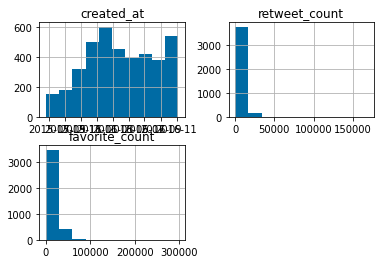

In [21]:
# 3.5 Get histograms for numerical data
df.hist()
plt.show

In [22]:
# 3.6 Make a plot of tweets frequence rate by source
df_plot=(df
         .assign(hour=df['created_at'].dt.hour)
         .groupby(['source','hour'])
         .agg(count=('source','count')) 
         .assign(rate=lambda df: df['count']/df.groupby('source')['count'].sum())
         .reset_index())
df_plot


,source,hour,count,rate
0,Twitter for Android,0,98,0.053059
1,Twitter for Android,1,159,0.086086
2,Twitter for Android,2,194,0.105035
3,Twitter for Android,3,210,0.113698
4,Twitter for Android,4,132,0.071467
5,Twitter for Android,5,88,0.047645
6,Twitter for Android,6,61,0.033027
7,Twitter for Android,7,45,0.024364
8,Twitter for Android,8,40,0.021657
9,Twitter for Android,9,43,0.023281


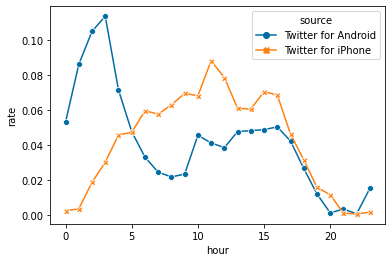

In [24]:
# 3.7 Get a glimpse of the most retweeted tweets
sns.lineplot(data=df_plot,x='hour',y='rate',hue='source',markers=True, style='source', dashes=False)
plt.show()

In [28]:
# 3.8 Get a glimpse of the most liked tweets
df.sort_values(by='retweet_count', ascending=False)[['text','retweet_count']][:10]

,text,retweet_count
2446,How long did it take your staff of 823 people ...,168765
2711,Happy #CincoDeMayo! The best taco bowls are ma...,85465
1132,MAKE AMERICA GREAT AGAIN!,59098
1476,Here is my statement. https://t.co/WAZiGoQqMQ,51891
2156,Such a great honor to be the Republican Nomine...,41616
1139,If Obama worked as hard on straightening out o...,41479
1545,For those few people knocking me for tweeting ...,40850
1474,The media and establishment want me out of the...,40772
2188,I am pleased to announce that I have chosen Go...,38782
2421,Is President Obama going to finally mention th...,38456


In [27]:
# 3.9 Let's get a glimpse of common words in the tweets' text
df.sort_values(by='favorite_count', ascending=False)[['text','favorite_count']][:10]

,text,favorite_count
2446,How long did it take your staff of 823 people ...,297281
2156,Such a great honor to be the Republican Nomine...,129652
1476,Here is my statement. https://t.co/WAZiGoQqMQ,120244
1499,Mike Pence won big. We should all be proud of ...,120189
2711,Happy #CincoDeMayo! The best taco bowls are ma...,119759
1132,MAKE AMERICA GREAT AGAIN!,115387
1545,For those few people knocking me for tweeting ...,107497
1474,The media and establishment want me out of the...,105680
1139,If Obama worked as hard on straightening out o...,102045
2188,I am pleased to announce that I have chosen Go...,92250


In [29]:
# 3.10 Process text to extract stopwords
df['text'].str.split(expand=True).stack().value_counts()[:10]

the    1965
to     1369
and    1186
I      1133
in     1098
a       987
of      957
is      904
on      829
for     703
dtype: int64

In [30]:
#sacamos mayu
df['text_clean']=df['text'].str.lower()

In [33]:
#lambda me permite darle argumentos a la funcion.
stop_dict=stopwords.words('english')
df['text_clean']=df['text_clean'].apply(lambda x: clean_stopwords(x,stop_dict=stop_dict))
df['text_clean']=df['text_clean'].str.replace(r'''['!,.]''','',regex=True)


In [34]:
# 3.11 Extract urls
##esta linkeando a una imagen:
url_pat = 'https://t.co/[A-Za-z\d]+|&amp;'
df['text_clean']=df['text_clean'].str.replace(url_pat,'',regex=True)

In [35]:
# 3.12 Extract special characters
df['text_clean']=df['text_clean'].str.replace(r'''[!.,():\-%$/'"']''','',regex=True)

In [36]:
# 3.13 Extract numbers
df['text_clean']=df['text_clean'].str.replace(r'[\d]+','',regex=True)

In [37]:
# 3.14 See the results
df[['text','text_clean']].sample(10)

,text,text_clean
1240,"As election looms, some bad news for Clinton, ...",election looms bad news clinton democrats http...
1610,Many on the team and staff of Bernie Sanders h...,many team staff bernie sanders treated badly h...
2537,The media is on a new phony kick about my mana...,media new phony kick management style spend mu...
1748,Crooked Hillary's V.P. pick said this morning ...,crooked hillarys vp pick said morning aware ru...
1033,I hear that sleepy eyes @chucktodd will be fir...,hear sleepy eyes @chucktodd fired like dog rat...
1864,Join me in North Carolina - tomorrow at 7:30pm...,join north carolina tomorrow pm #imwithyou ti...
2952,This was the reporters statement- when she fou...,reporters statement found tape facility change...
3903,We could only get a small fraction of this 25k...,could get small fraction k crowd in movement m...
3242,"Because of me, the Republican Party has taken ...",me republican party taken millions new voters ...
1855,The reporting at the failing @nytimes gets wor...,reporting failing @nytimes gets worse worse da...


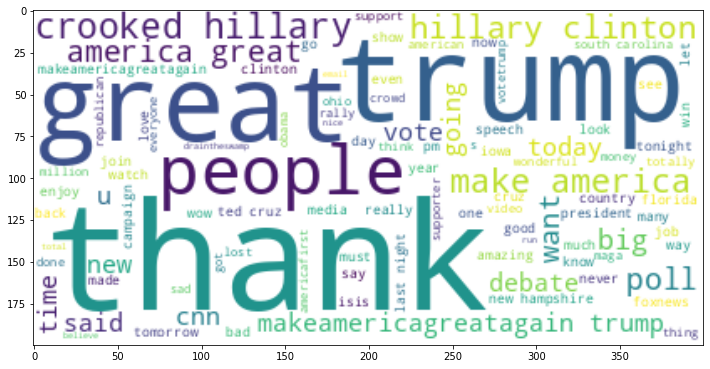

In [40]:
# 3.15 Let's see a wordcloud
#relevancia de palabras que llaman la atencion
text =' '.join([i for i in df.text_clean])
word_cloud=WordCloud(max_words=100,background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(word_cloud,interpolation='bilinear')
plt.show()


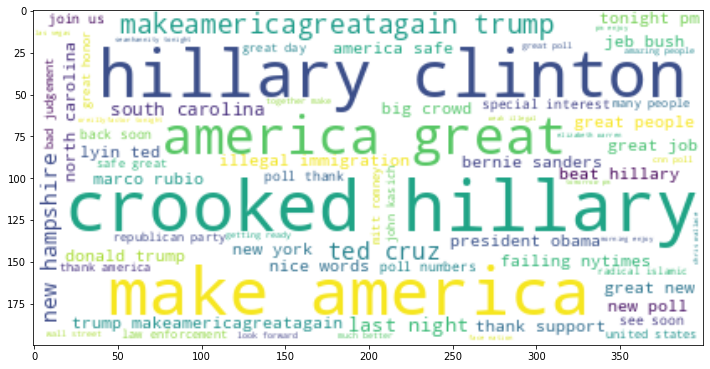

In [41]:
#dos palabras que se repiten una y otra vez juntas
wordcloud=WordCloud(collocation_threshold=2,collocations=True,max_words=100,background_color='White').generate(text)
plt.figure(figsize=(12,12))
plt.imshow(wordcloud,interpolation='bilinear')
plt.show()

In [42]:
#trocer el texto y asociar un sentimiento a esas palabras
df_word_split=(df
               .drop(['text','created_at','retweet_count','favorite_count'],axis=1)
               .assign(text=df['text_clean'].str.split())).explode('text').drop('text_clean',axis=1).rename(columns={'text':'word'})
df_word_split

,source,word
0,Twitter for Android,would
0,Twitter for Android,like
0,Twitter for Android,wish
0,Twitter for Android,everyone
0,Twitter for Android,happy
...,...,...
3945,Twitter for Android,together
3945,Twitter for Android,make
3945,Twitter for Android,america
3945,Twitter for Android,great


In [45]:
#aplicamos un join
df_word_split.merge(nrc[['word','sentiment']],on='word',how='inner')

,source,word,sentiment
0,Twitter for Android,happy,anticipation
1,Twitter for Android,happy,joy
2,Twitter for Android,happy,positive
3,Twitter for Android,happy,trust
4,Twitter for iPhone,happy,anticipation
...,...,...,...
17547,Twitter for Android,stiff,negative
17548,Twitter for Android,embarrassment,fear
17549,Twitter for Android,embarrassment,negative
17550,Twitter for Android,embarrassment,sadness


In [49]:
#backslash permite hacer multilinea
df_sent=df_word_split.\
    merge(nrc[['word','sentiment']],on='word',how='inner').\
    groupby(['source','sentiment']).agg(count=('sentiment','count')).\
    reset_index().pivot_table(index=['sentiment'],columns=['source'],values='count').\
    reset_index().\
    rename(columns={'Twitter for Android':'Android','Twitter for iPhone':'Iphone'})
df_sent

source,sentiment,Android,Iphone
0,anger,949,514
1,anticipation,986,725
2,disgust,632,307
3,fear,815,477
4,joy,743,543
5,negative,1671,925
6,positive,1963,1522
7,sadness,911,512
8,surprise,587,385
9,trust,1363,1022


In [50]:
#frecuencias relativas
#odd ratio
#vamos a calcular un intervalo de confianza
df_odd_ratio=df_sent.\
             assign(odd_ratio=(df_sent['Android']/(df_sent['Android'].sum()-df_sent['Android']))/(df_sent['Iphone']/(df_sent['Iphone'].sum()-df_sent['Iphone'])))
df_odd_ratio['log_or']=np.log(df_odd_ratio['odd_ratio'])

In [51]:
df_odd_ratio.sort_values(by='log_or',ascending=False)

source,sentiment,Android,Iphone,odd_ratio,log_or
2,disgust,632,307,1.365482,0.311508
0,anger,949,514,1.225269,0.203160
5,negative,1671,925,1.212601,0.192767
7,sadness,911,512,1.176546,0.162583
3,fear,815,477,1.124833,0.117634
8,surprise,587,385,0.994922,-0.005091
4,joy,743,543,0.885109,-0.122044
1,anticipation,986,725,0.876222,-0.132136
9,trust,1363,1022,0.851456,-0.160808
6,positive,1963,1522,0.806001,-0.215670


cuando es positivo el log_or es porque son sentimientos de andoid
nos da negativo cuando son palabras tiradas por el iphone.

El andoid esta mas asociado con sentimientos malos.

Detras de esos dos celulares parceria haber dos personas distintas.

In [ ]:
#como saber que esos rsultados no se dieron al azar 
#si el intervalo de confianza contiene 0 no estoy seguro porque el p value seria muy chico
#si contiene el cero no podria afirmar que los sentimientos del apple o android son de cierta forma

In [56]:
#el intervalo de confianza aplicada para odd_ratio
df_odd_ratio['se']=np.sqrt(1/df_odd_ratio['Android']+1/(df_odd_ratio['Android'].sum()-df_odd_ratio['Android'])+1/df_odd_ratio['Iphone']+1/(df_odd_ratio['Iphone'].sum()-df_odd_ratio['Iphone']))
#asumimos dist normal por el vol de datos que tenemos
df_odd_ratio['conf_low']=df_odd_ratio['log_or']-norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio['conf_high']=df_odd_ratio['log_or']+norm.ppf(0.975)*df_odd_ratio['se']
df_odd_ratio.sort_values(by='log_or',ascending=True)


source,sentiment,Android,Iphone,odd_ratio,log_or,se,conf_low,conf_high
6,positive,1963,1522,0.806001,-0.215670,0.038299,-0.290735,-0.140606
9,trust,1363,1022,0.851456,-0.160808,0.044602,-0.248227,-0.073388
1,anticipation,986,725,0.876222,-0.132136,0.051560,-0.233192,-0.031081
4,joy,743,543,0.885109,-0.122044,0.058697,-0.237087,-0.007001
8,surprise,587,385,0.994922,-0.005091,0.067479,-0.137347,0.127165
3,fear,815,477,1.124833,0.117634,0.059836,0.000358,0.234910
7,sadness,911,512,1.176546,0.162583,0.057529,0.049828,0.275338
5,negative,1671,925,1.212601,0.192767,0.044246,0.106046,0.279489
0,anger,949,514,1.225269,0.203160,0.057083,0.091280,0.315041
2,disgust,632,307,1.365482,0.311508,0.071349,0.171666,0.451349


Intervalo de confianza no contiene cero, es probable q pertenezca a Andrioid. Si contiene cero puede ser que sea al azar. esta bien separad la emociones positivas con las negativas.

Sorpresa si contiene cero, entonces no podria saber si es android o iphone.

Mayores a cero en odd ratio es del valores de referncia, todo lo que sea poaisitvo en odd ratio es andriod. Si el resultado de odd ratio es negativo seria q corresponde a iphone.

Puedo decir que la persona del andriod realiza comentarios mas negativos

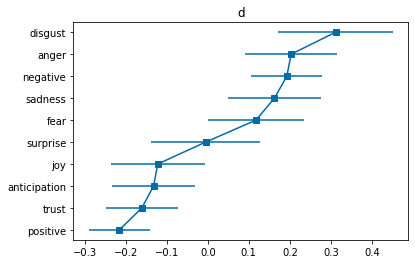

In [66]:
df_odd_ratio=df_odd_ratio.sort_values(by='log_or',ascending=True)
plt.errorbar(df_odd_ratio['log_or'],df_odd_ratio['sentiment'],marker='s',xerr=((df_odd_ratio.log_or-df_odd_ratio.conf_low),(df_odd_ratio.conf_high-df_odd_ratio.log_or)))
plt.title('d')
plt.show()

Solo surprise tiene el cero incluido.
El disgutos esta bien lejos del cero y es una caracteristica propia del andrioid.


nos falta knn means, cadenas de mrkow, hallar entidades si es verbo o sustantivo, etc.